In [467]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from scipy.optimize import curve_fit
import lmfit
from lmfit import Model
from lmfit import Parameters


In [468]:
filename_prefix = "/Users/olivershen/Library/CloudStorage/GoogleDrive-shenzongqi2000@gmail.com/.shortcut-targets-by-id/1kZAJHBlurAxVO65haJzlqoIV3f2UO_JV/20250409_Gedik_1st_011/Data/"

## L scan

In [489]:
def read_file(df):
    timelist = df[df.columns[0]].to_numpy()
    time = timelist.tolist()
    
    onlist = df[df.columns[1]].to_numpy()
    on = onlist.tolist()
    
    offlist = df[df.columns[2]].to_numpy()
    off = offlist.tolist()
    result = []
    end_index = len(on)
    
    for i in range(end_index):
        result.append((on[i]))
    X= np.array(time)
    Y = np.array(result)
    # Polynomial fit (e.g., 3rd order)
    #p = np.polyfit(X, Y, 3)
   # background = np.polyval(p, X)
    
    return X,Y

In [490]:
index = range(464,491)
file_lists = [filename_prefix+"ue_20250409_" + str(i) + ".csv" for i in index]

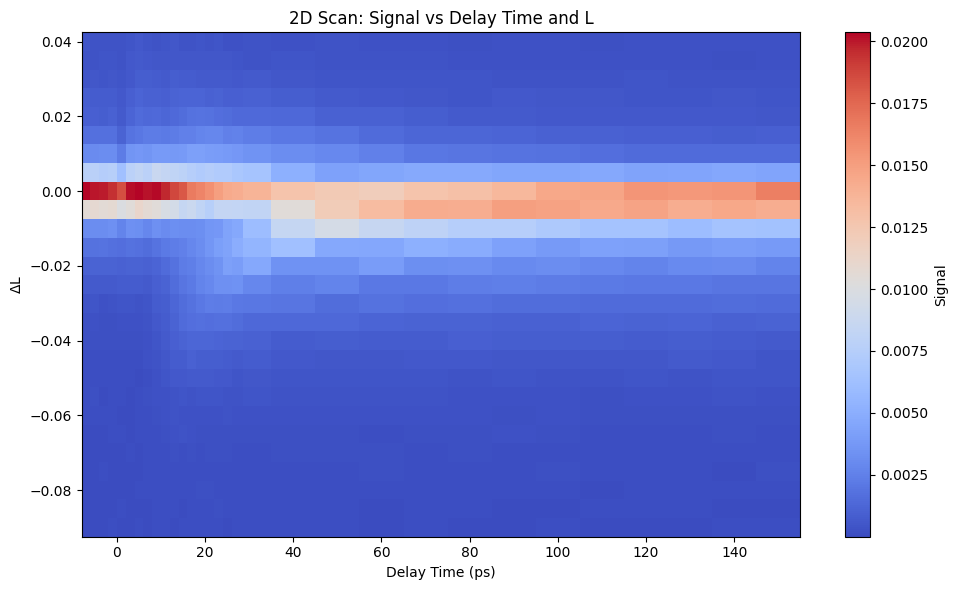

In [491]:
# === Customize these ===
deltaL = [-0.09+0.005*i for i in range(len(index))]
all_signals = []
a=0
for file in file_lists:
    df = pd.read_csv(file)
    delay_time,signal = read_file(df)
    if index[a]==391:
        delay_time = np.append(delay_time ,150)
        signal = np.append(signal,signal[-1])
    a = a + 1
    all_signals.append(signal)
        

# Convert list of signals to 2D array (angle x delay_time)
signal_matrix = np.array(all_signals)

# Create meshgrid for plotting
X, Y = np.meshgrid(delay_time,deltaL)

# Plot
plt.figure(figsize=(10,6))
plt.pcolormesh(X, Y, signal_matrix, shading='auto', cmap='coolwarm')
plt.colorbar(label='Signal')
plt.xlabel('Delay Time (ps)')
plt.ylabel('$\Delta$L')
plt.title('2D Scan: Signal vs Delay Time and L')
plt.tight_layout()
plt.show()


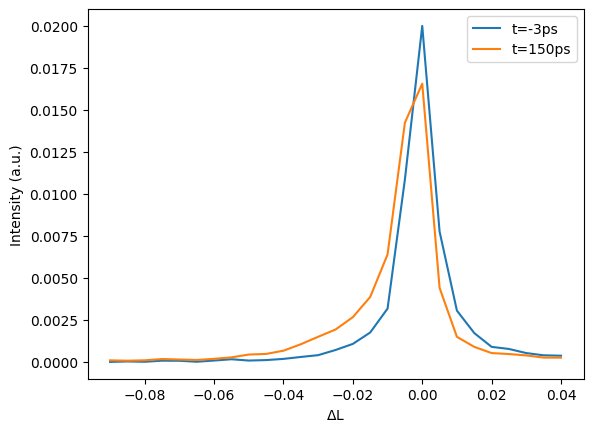

In [492]:
plt.plot(deltaL,signal_matrix[:,1],label='t=-3ps')
plt.plot(deltaL,signal_matrix[:,-1],label='t=150ps')
plt.xlabel(r'$\Delta$L')
plt.ylabel('Intensity (a.u.)')
plt.legend()

### fitting the two peaks

In [493]:
def double_lorentzian(x, a1, gamma1, a2, x02, gamma2, offset):
    L1 = a1 * gamma1**2 / ((x)**2 + gamma1**2)
    L2 = a2 * gamma2**2 / ((x - x02)**2 + gamma2**2)
    return L1 + L2 + offset
lorentz_model = Model(double_lorentzian)

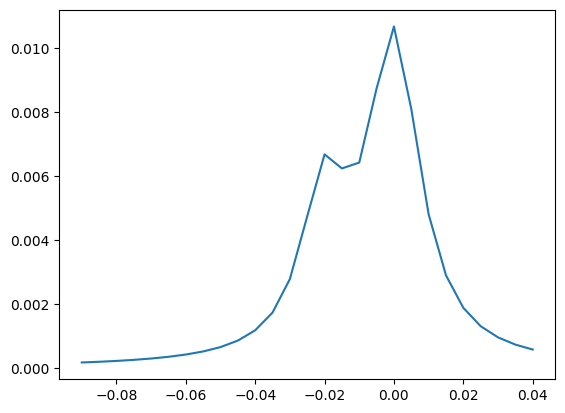

In [494]:
plt.plot(np.array(deltaL),double_lorentzian(np.array(deltaL), 0.01, 0.009, 0.005, -0.02, 0.008, 0))

In [495]:
 param_dict = {
    'a1': {'value': 0.01, 'min': 0, 'max': 0.04},
    'gamma1': {'value': 0.009, 'min': 0, 'max': 0.1},
    'a2': {'value': 0.005, 'min': 0, 'max': 0.03},
    'x02': {'value': -0.02, 'min': -0.08, 'max': 0},
    'gamma2': {'value': 0.009, 'min': 0, 'max': 0.1},
    'offset': {'value': 0, 'min': 0, 'max': 0.0001}
}

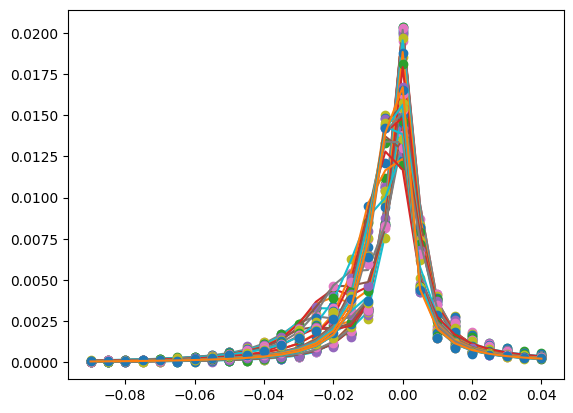

In [496]:
fit_signals = []
params1={}
for i in range(len(delay_time)):
    profile = signal_matrix[:,i]
    # Initial guess: [a1, gamma1, a2, x02, gamma2, offset]
    params = Parameters()
    for name, settings in param_dict.items():
        params.add(name, **settings)
    result = lorentz_model.fit(np.array(profile), params, x=np.array(deltaL),method='cg')
    params1[i]=[result.params[param].value for param in result.params]
    # Evaluate fit
    fit_signals.append(result.best_fit)
  
    plt.plot(np.array(deltaL), np.array(profile), 'o', label='Original Data')
    plt.plot(np.array(deltaL), result.best_fit, '-', label='Double Lorentzian Fit')

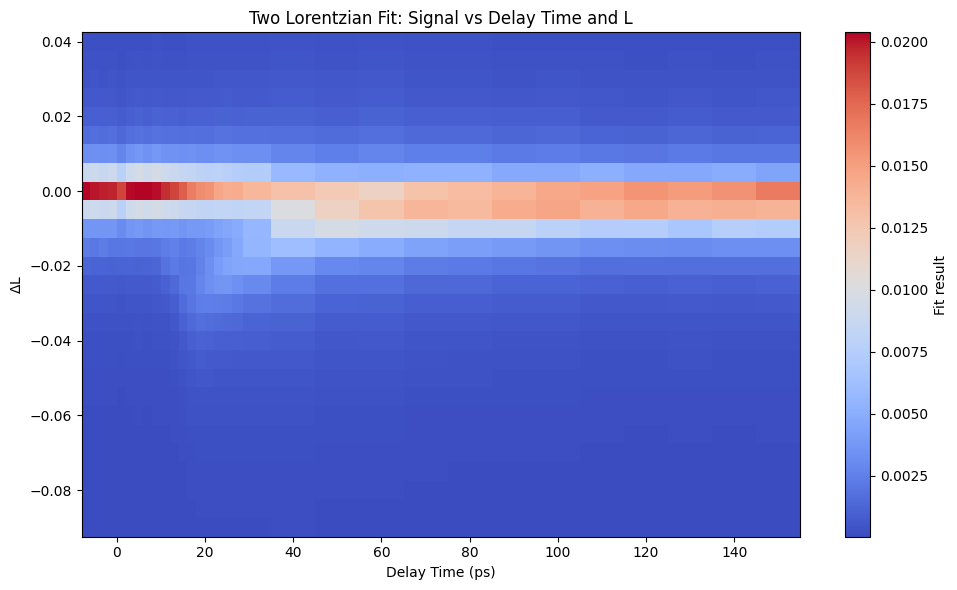

In [497]:
# Convert list of signals to 2D array (angle x delay_time)
fit_matrix = np.array(fit_signals).transpose()

# Create meshgrid for plotting
X, Y = np.meshgrid(delay_time,deltaL)

# Plot
plt.figure(figsize=(10,6))
plt.pcolormesh(X, Y, fit_matrix, shading='auto', cmap='coolwarm')
plt.colorbar(label='Fit result')
plt.xlabel('Delay Time (ps)')
plt.ylabel('$\Delta$L')
plt.title('Two Lorentzian Fit: Signal vs Delay Time and L')
plt.tight_layout()
plt.show()

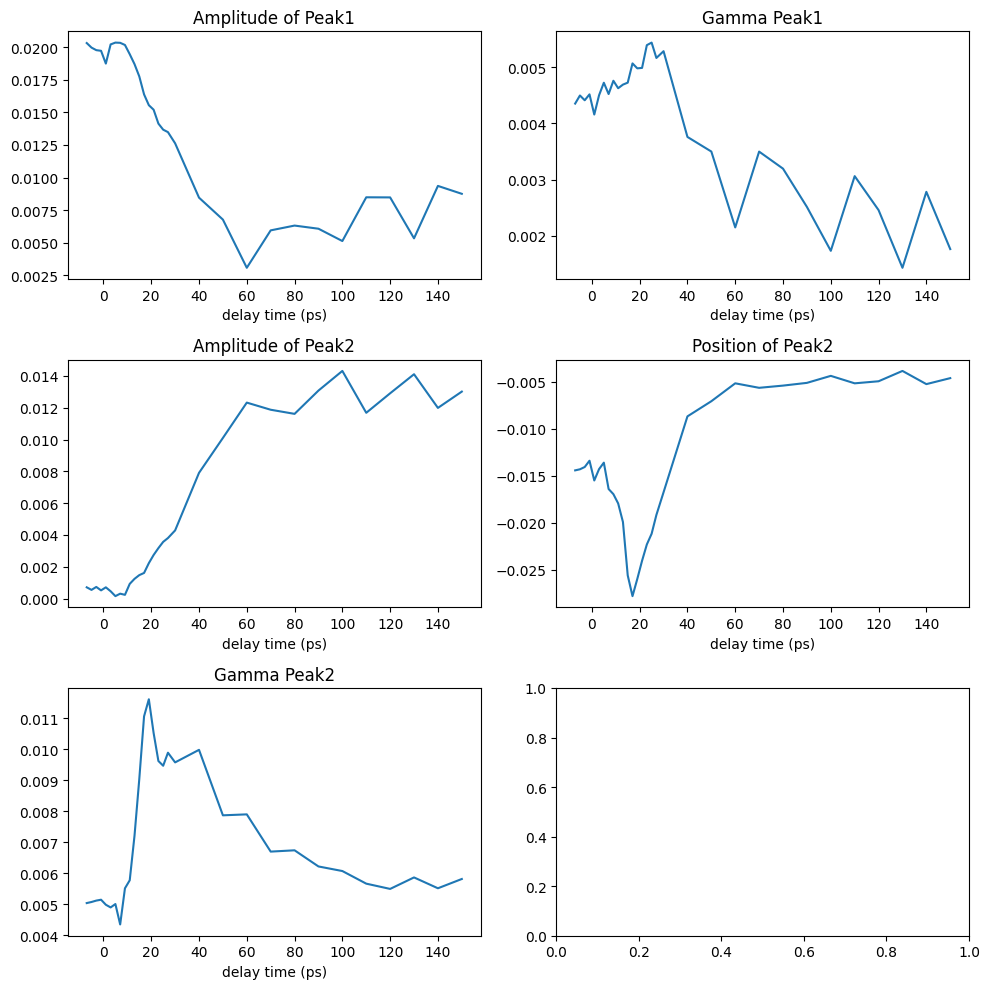

In [498]:
#[a1, gamma1, a2, x02, gamma2, offset]
ylabels = ['Amplitude of Peak1', 'Gamma Peak1', 'Amplitude of Peak2',
           'Position of Peak2', 'Gamma Peak2']

fig, axes = plt.subplots(3, 2, figsize=(10, 10))
axes = axes.flatten()

for i in range(5):
    axes[i].plot(delay_time, [params1[t][i] for t in range(len(delay_time))])
    axes[i].set_xlabel('delay time (ps)')
    axes[i].set_title(ylabels[i])


plt.tight_layout()
plt.show()


Text(0, 0.5, 'Intensity')

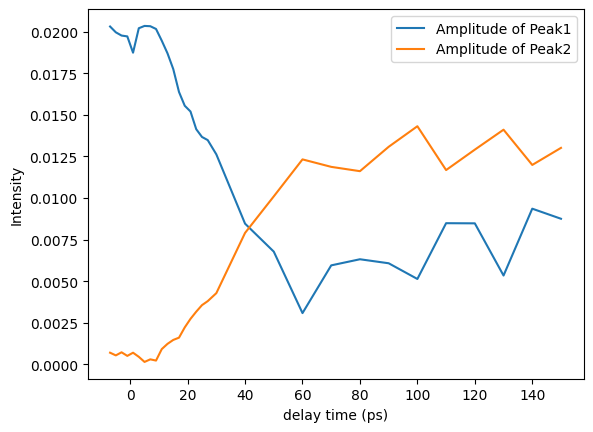

In [499]:
#a1, gamma1, a2, x02, gamma2, offset
plt.plot(delay_time, [params1[t][0] for t in range(len(delay_time))],label='Amplitude of Peak1')
plt.plot(delay_time, [params1[t][2] for t in range(len(delay_time))],label='Amplitude of Peak2')
plt.legend()
plt.xlabel('delay time (ps)')
plt.ylabel('Intensity')

Text(0, 0.5, 'Gamma')

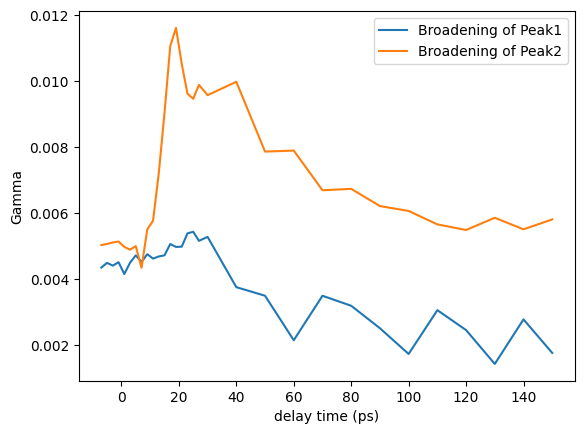

In [500]:
#a1, gamma1, a2, x02, gamma2, offset
plt.plot(delay_time, [params1[t][1] for t in range(len(delay_time))],label='Broadening of Peak1')
plt.plot(delay_time, [params1[t][4] for t in range(len(delay_time))],label='Broadening of Peak2')
plt.legend()
plt.xlabel('delay time (ps)')
plt.ylabel('Gamma')

Text(0, 0.5, 'K_2')

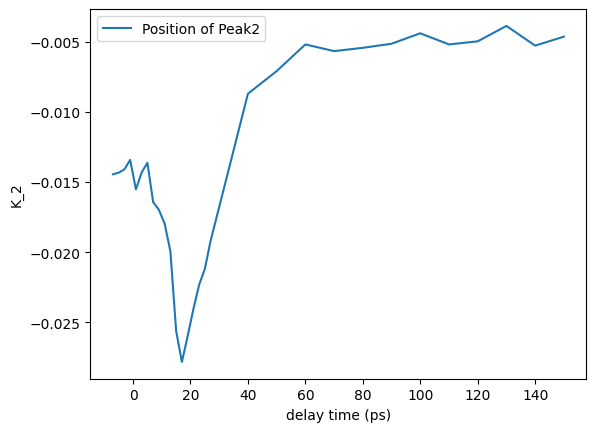

In [501]:
#a1, gamma1, a2, x02, gamma2, offset
plt.plot(delay_time, [params1[t][3] for t in range(len(delay_time))],label='Position of Peak2')
plt.legend()
plt.xlabel('delay time (ps)')
plt.ylabel('K_2')

## K scan

In [528]:
def read_file(df):
    timelist = df[df.columns[0]].to_numpy()
    time = timelist.tolist()
    
    onlist = df[df.columns[1]].to_numpy()
    on = onlist.tolist()
    
    offlist = df[df.columns[2]].to_numpy()
    off = offlist.tolist()
    result = []
    end_index = len(on)
    
    for i in range(end_index):
        result.append(on[i]-off[i])
    X= np.array(time)
    Y = np.array(result)
    # Polynomial fit (e.g., 3rd order)
    #p = np.polyfit(X, Y, 3)
   # background = np.polyval(p, X)
    
    return X,Y

In [529]:
index1 = range(493,502)
index2 = range(503,515)
index3 = range(516,524)

file_lists1 = [filename_prefix+"ue_20250409_" + str(i) + ".csv" for i in index1]
file_lists2 = [filename_prefix+"ue_20250409_" + str(i) + ".csv" for i in index2]
file_lists3 = [filename_prefix+"ue_20250409_" + str(i) + ".csv" for i in index3]
file_lists = file_lists1 + file_lists2

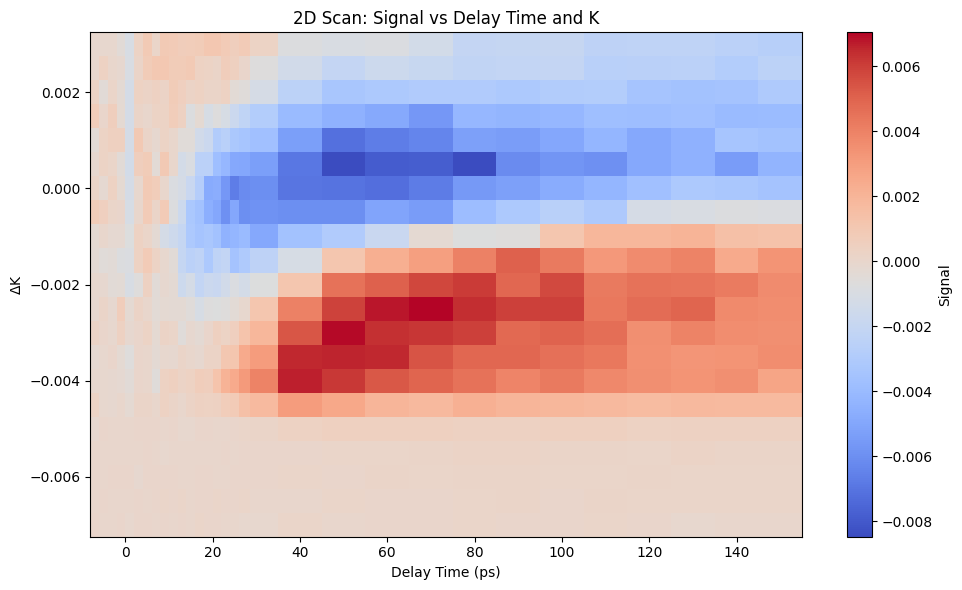

In [530]:
# === Customize these ===
deltaK = [-0.007+0.0005*i for i in range(len(index1)+len(index2))]
all_signals = []
a=0
for file in file_lists:
    df = pd.read_csv(file)
    
    delay_time,signal = read_file(df)
    all_signals.append(signal) 
    a = a + 1
    
# Convert list of signals to 2D array (angle x delay_time)
signal_matrix = np.array(all_signals)

# Create meshgrid for plotting
X, Y = np.meshgrid(delay_time,deltaK)


# Plot
plt.figure(figsize=(10,6))
plt.pcolormesh(X, Y, signal_matrix, shading='auto', cmap='coolwarm')
plt.colorbar(label='Signal')
plt.xlabel('Delay Time (ps)')
plt.ylabel('$\Delta$K')
plt.title('2D Scan: Signal vs Delay Time and K')
plt.tight_layout()
plt.show()


In [526]:
delay_time[-1]

150

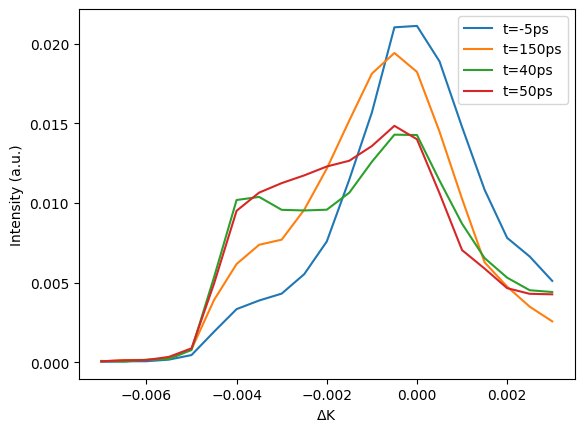

In [527]:
plt.plot(deltaK,signal_matrix[:,1],label='t=-5ps')
plt.plot(deltaK,signal_matrix[:,-1],label='t=150ps')
plt.plot(deltaK,signal_matrix[:,19],label='t=40ps')
plt.plot(deltaK,signal_matrix[:,20],label='t=50ps')
plt.xlabel(r'$\Delta$K')
plt.ylabel('Intensity (a.u.)')
plt.legend()